In [1]:
import pandas as pd 
import numpy as np
import os
import cv2 
import random
import string
import boto3

from keras.models import Sequential, Model, load_model
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, optimizers

import matplotlib.pyplot as plt
from IPython.display import Image

%pylab inline

Using TensorFlow backend.


In [2]:
!aws --version

aws-cli/1.16.174 Python/3.7.3 Linux/4.15.0-1040-aws botocore/1.12.164


### Model 4: 

In [5]:
test_dataset = '/home/ubuntu/project-5/data/model-4/train'
train_dataset = '/home/ubuntu/project-5/data/model-4/validate'

In [8]:
# All images will be rescaled by 1./255

train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        train_dataset,
        target_size=(150, 150), # resize images to 150x150
        batch_size=20,
        class_mode='binary') # use binary labels for binary_crossentropy loss

validation_generator = test_datagen.flow_from_directory(
        test_dataset,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 250 images belonging to 2 classes.
Found 1440 images belonging to 2 classes.


In [9]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [10]:
# Use VGG-16 + ImageNet base, freezing top layers train for our specific species:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150, 3))     
 
# Freeze convolutional layers:

for layer in base_model.layers:
    layer.trainable = False    
    
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 

predictions = Dense(2, activation='softmax')(x)

# model to train:

model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
            loss= "sparse_categorical_crossentropy", metrics=['accuracy']) 

In [12]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/2
  1/100 [..............................] - ETA: 11:23 - loss: 0.8201 - acc: 0.6000

/home/ubuntu/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 69337600 bytes but only got 0. Skipping tag 3072
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 11. 
  warnings.warn(str(msg))


100/100 [==============================] - 633s 6s/step - loss: 0.6752 - acc: 0.6040 - val_loss: 0.5682 - val_acc: 0.7050
Epoch 2/2
100/100 [==============================] - 632s 6s/step - loss: 0.5154 - acc: 0.7475 - val_loss: 0.4838 - val_acc: 0.7670


In [8]:
model.save('./data/model-4.h5')

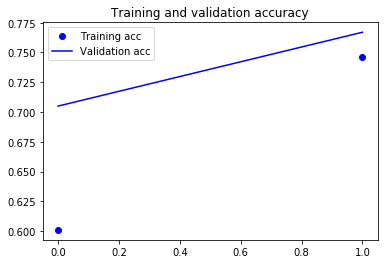

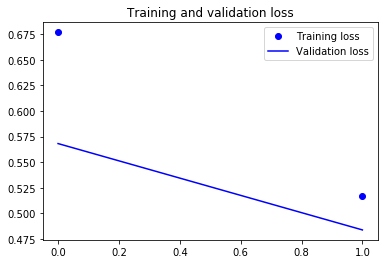

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Test Model:

In [43]:
def prepare_image(image_path):
    im = cv2.resize(cv2.imread(image_path), (150, 150)).astype(np.float32)
    im = np.expand_dims(im, axis=0)
    return im

In [44]:
# Create SNS client:

client = boto3.client(
    "sns",
    aws_access_key_id = 'access_key_id',
    aws_secret_access_key = 'secret_access_key',
    region_name = "us-east-1"
)

In [45]:
model = load_model('./data/model-4.h5')

1/1 [==============================] - 0s 199ms/step
Feral Pig


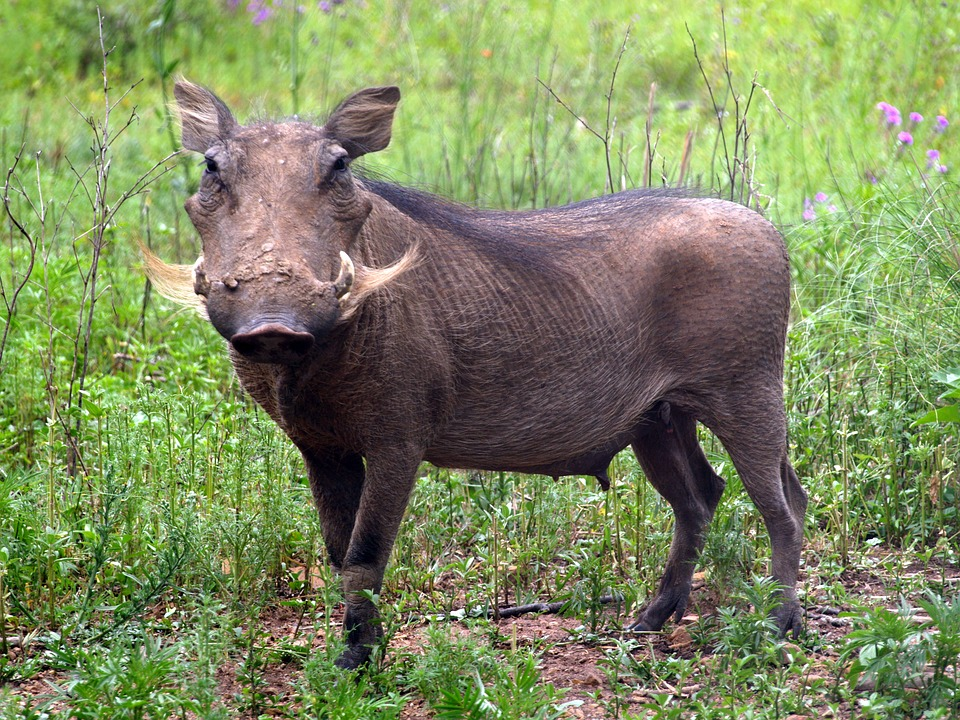

In [47]:
path = '/home/ubuntu/project-5/data/images/test/'

ftest = random.sample(os.listdir(path), k = 1)
ftest = path + ftest[0]

img = prepare_image(ftest)

out = model.predict(img, verbose = 1)
y_pred = np.argmax(out)

msg = 'Feral Pig'

if y_pred == 1:
    msg = 'Whitetail Deer'
k = out[0][y_pred]

client.publish(
    PhoneNumber = '+18005555555',
    Message = msg
)

print(msg)

Image(filename = ftest)